<a href="https://colab.research.google.com/github/vishnudas-raveendran/PGP-AIML/blob/master/NLP/Project1/NLP_Project_1_Part_A_Blog_Label_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A

The need is to build a NLP classifier which can use input text parameters to determine the label/s of the blog.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
!mkdir new
!cp '/content/drive/MyDrive/GL Project Dataset/archive (1).zip' '/content/new/'


In [3]:
!unzip '/content/new/archive (1).zip' -d '/content/'

Archive:  /content/new/archive (1).zip
  inflating: /content/blogtext.csv   


## 1. Import Dataset

In [4]:
data = pd.read_csv('blogtext.csv')

In [5]:
data.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

### 1.2 Clean dataset

In [6]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [7]:
data.shape

(681284, 7)

In [8]:
#Check for null values
pd.DataFrame(data.isnull().sum(), columns=['No. of missing values'])

,No. of missing values
id,0
gender,0
age,0
topic,0
sign,0
date,0
text,0


In [9]:
print(f"There are {data.duplicated().sum()} duplicate rows")

There are 4686 duplicate rows


In [10]:
data.drop_duplicates(inplace=True)

## 2. EDA

Get all unique values in columns

In [11]:
for col in data.columns:
  if not col in ['id','date','text']:
    print(col)
    print("."*40)
    print(data[col].unique())
    print(data[col].value_counts())
    print("\n")

gender
........................................
['male' 'female']
male      342272
female    334326
Name: gender, dtype: int64


age
........................................
[15 33 14 25 17 23 37 26 24 27 45 34 41 44 16 39 35 36 46 42 13 38 43 40
 47 48]
17    80670
24    79809
23    72448
16    72228
25    66803
26    55012
27    45745
15    41559
14    27200
34    21304
33    17532
35    17275
36    14185
13    12132
37     9280
38     7187
39     5468
40     4998
45     4468
43     4195
41     3714
48     3545
42     2875
46     2730
47     2204
44     2032
Name: age, dtype: int64


topic
........................................
['Student' 'InvestmentBanking' 'indUnk' 'Non-Profit' 'Banking' 'Education'
 'Engineering' 'Science' 'Communications-Media' 'BusinessServices'
 'Sports-Recreation' 'Arts' 'Internet' 'Museums-Libraries' 'Accounting'
 'Technology' 'Law' 'Consulting' 'Automotive' 'Religion' 'Fashion'
 'Publishing' 'Marketing' 'LawEnforcement-Security' 'HumanResources'
 'Telecomm

In [12]:
data.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

### 2.1 Univariate Analysis

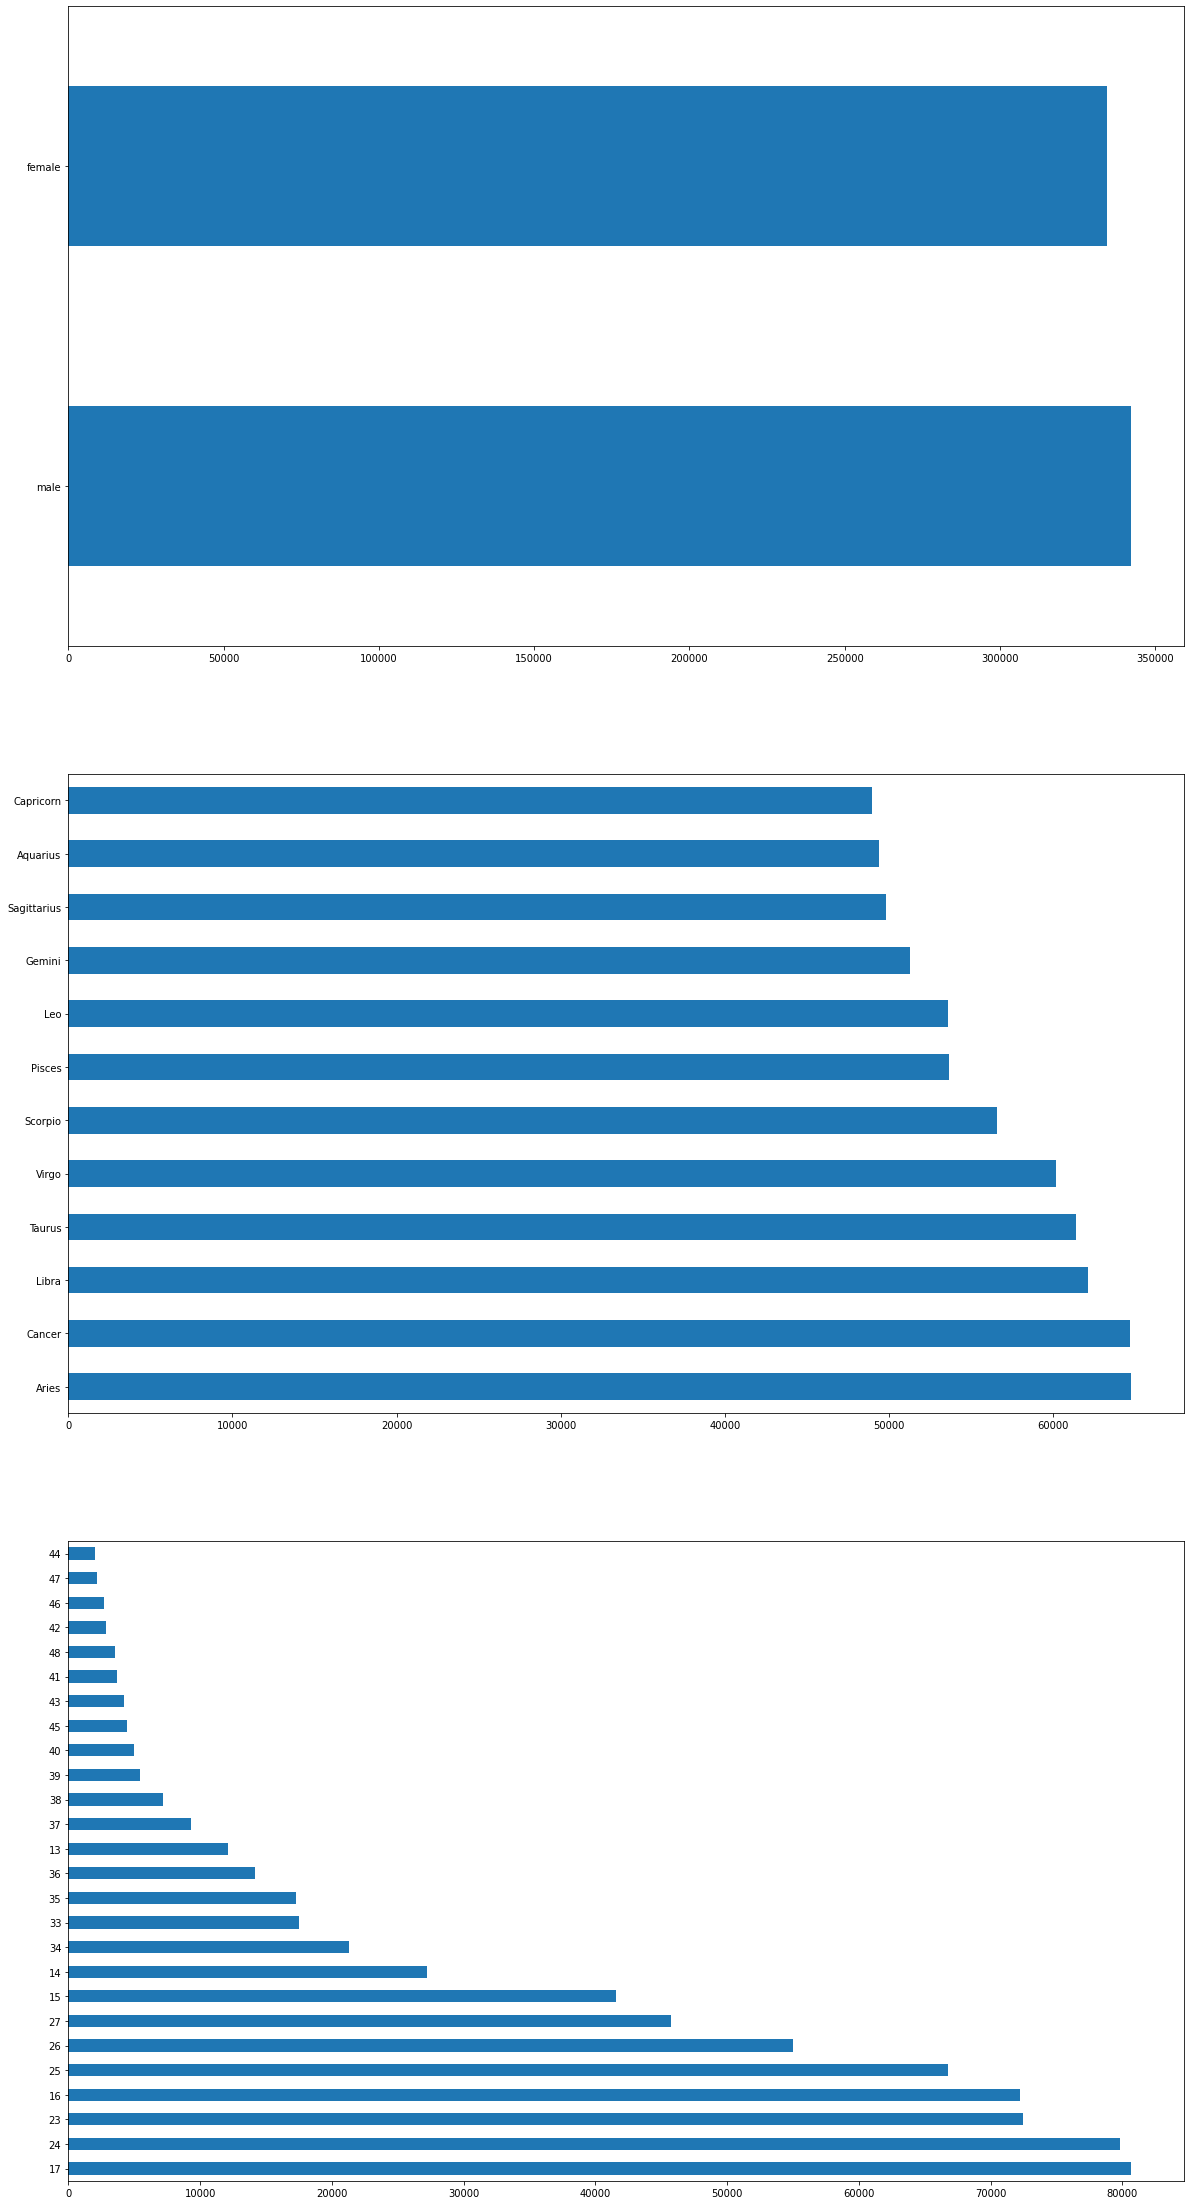

In [13]:
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(60,20))
data['gender'].value_counts().plot(kind = 'barh',  figsize = (20, 40),ax=ax[0]);
data['sign'].value_counts().plot(kind = 'barh',  figsize = (20, 40),ax=ax[1]);
data['age'].value_counts().plot(kind = 'barh',  figsize = (20, 40),ax=ax[2]);
plt.show()

Analysis of text

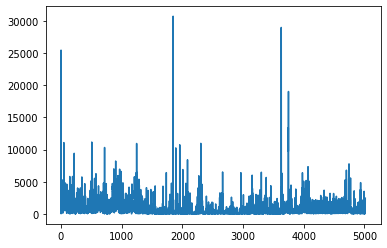

In [14]:
data['text'][0:5000].str.len().plot();

In [15]:
tlen = data['text'].str.len()

print('Minimum line length: {}'.format(tlen.min()))
print('Maximum line length: {}'.format(tlen.max()))
print('Std deviation line length: {}'.format(tlen.std()))

Minimum line length: 4
Maximum line length: 790123
Std deviation line length: 2334.408598129339


Most of the blog length is around an average of 2334 characters

In [16]:
# Select a smaller subset of dataset
data = data[0:7000]

In [17]:
data.shape

(7000, 7)

### 2.2 Data Cleaning

In [18]:
!pip install contractions
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

     |████████████████████████████████| 106 kB 19.0 MB/s 
     |████████████████████████████████| 284 kB 54.9 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [19]:
# Pipeline for text cleaning

def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text

def tokenize(text):
    return nltk.word_tokenize(text)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def replace_numbers(words):
    """Replace all integer occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_numbers(words):
    """Remove all integer occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = ''
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [20]:
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [21]:
def text_clean(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text
data['text'] = [text_clean(x) for x in data['text']]

In [22]:
data['text'].head(5)

0    info find  page  mb pdf file wait untill team ...
1    team members drewes van der laag urllink mail ...
2    het kader van kernfusie op aarde maak je eigen...
3                                            test test
4    thank yahoo toolbar capture urls popups mean s...
Name: text, dtype: object

### 2.3 Target/label merger and transformation

In [23]:
data.dtypes

id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

In [24]:
data["age"] = data["age"].astype(str)
data["labels"] = data.apply(lambda col :[col["gender"],col["age"],col["topic"],col["sign"]],axis =1)

In [25]:
data.drop(columns=["gender","age","sign","topic","date","id"],axis =1, inplace = True)

In [26]:
data.head()

,text,labels
0,info find page mb pdf file wait untill team ...,"[male, 15, Student, Leo]"
1,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,test test,"[male, 15, Student, Leo]"
4,thank yahoo toolbar capture urls popups mean s...,"[male, 33, InvestmentBanking, Aquarius]"


### 2.4 Train-Test Split

In [27]:
X_train, X_test, y_train, y_test =train_test_split(data.text,data.labels, random_state=42,test_size = 0.3,shuffle = True)

In [28]:
print(f"Training Size:{y_train.shape[0]} \n Test Size: {y_test.shape[0]}")

Training Size:4900 
 Test Size: 2100


### 2.5 Vectorize

#### 2.5.1 Count Vectorizer

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=3, max_features=100)  #have already removed stopewords earlier so not using it here again
vectorizer.fit(X_train)
X_count_vect=vectorizer.transform(X_train)

In [30]:
X_count_vect.toarray()
X_count_vect.shape

(4900, 100)

In [31]:
cv_X_train = pd.DataFrame(X_count_vect.todense(), columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
cv_X_train.head()

,actually,also,always,another,around,ask,back,better,call,come,...,way,week,well,work,world,would,write,year,years,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,7,1,0,0,0,0


In [33]:
cv_X_train.shape

(4900, 100)

#### 2.5.2 Tf_IDF Vectorizer

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer(min_df=3, max_features=1000)
tfidf_X = tfidfvectorizer.fit_transform(X_train)
tfidfvectorizer.get_feature_names_out()

array(['able', 'absolutely', 'accept', 'accord', 'account', 'across',
       'act', 'action', 'actually', 'add', 'address', 'administration',
       'admit', 'afraid', 'afternoon', 'age', 'ago', 'agree', 'ah',
       'ahead', 'air', 'al', 'album', 'allow', 'almost', 'alone', 'along',
       'already', 'alright', 'also', 'although', 'always', 'amaze',
       'america', 'american', 'americans', 'among', 'amount', 'angie',
       'angry', 'annoy', 'another', 'answer', 'anybody', 'anymore',
       'anyone', 'anything', 'anyway', 'anyways', 'apartment',
       'apparently', 'appear', 'apple', 'apply', 'area', 'arm', 'around',
       'arrive', 'art', 'article', 'ask', 'ass', 'assume', 'attack',
       'attempt', 'attention', 'avoid', 'away', 'awesome', 'baby', 'back',
       'bad', 'bag', 'ball', 'band', 'bank', 'bar', 'base', 'basically',
       'bc', 'beach', 'bear', 'beat', 'beautiful', 'become', 'bed',
       'begin', 'behind', 'believe', 'ben', 'best', 'better', 'beyond',
       'big', 

In [35]:
tfidf_X.toarray()
tfidf_X_train = pd.DataFrame(tfidf_X.todense(), columns = tfidfvectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


To apply ML models, the target labels are multiple hence we need to encode them using 0 and 1, similar to getdummies().
MultilabelBinarizer does this for us when we pass it a dictionary of labels

In [36]:
label_counts=dict()

for labels in data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1
        
label_counts

{'13': 9,
 '14': 167,
 '15': 354,
 '16': 73,
 '17': 912,
 '23': 142,
 '24': 378,
 '25': 267,
 '26': 112,
 '27': 691,
 '33': 101,
 '34': 538,
 '35': 2305,
 '36': 801,
 '37': 19,
 '39': 79,
 '41': 14,
 '42': 14,
 '44': 3,
 '45': 14,
 '46': 7,
 'Accounting': 2,
 'Aquarius': 349,
 'Aries': 3230,
 'Arts': 31,
 'Automotive': 14,
 'Banking': 16,
 'BusinessServices': 86,
 'Cancer': 238,
 'Capricorn': 88,
 'Communications-Media': 61,
 'Consulting': 18,
 'Education': 121,
 'Engineering': 119,
 'Fashion': 714,
 'Gemini': 88,
 'Internet': 47,
 'InvestmentBanking': 70,
 'Law': 3,
 'Leo': 208,
 'Libra': 425,
 'Museums-Libraries': 2,
 'Non-Profit': 47,
 'Pisces': 67,
 'Religion': 9,
 'Sagittarius': 706,
 'Science': 33,
 'Scorpio': 851,
 'Sports-Recreation': 77,
 'Student': 577,
 'Taurus': 709,
 'Technology': 2344,
 'Virgo': 41,
 'female': 2973,
 'indUnk': 2609,
 'male': 4027}

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer

binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [38]:
print(y_train)
print("-----")
print(y_test)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 1]]
-----
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 1]]


For multi-class classification, https://scikit-learn.org/stable/modules/classes.html#module-sklearn.multiclass 

There are two approches in ML, one-vs-rest and one-vs-one classification.

We will use One-vs-rest since it uses lesser computation

## Test Models

In [39]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

In [40]:
report=[]

### 1. OneVsRest with SVC and count vectorizer

In [41]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
clf = OneVsRestClassifier(SVC()).fit(cv_X_train, y_train)

In [42]:
X_test_cv = vectorizer.transform(X_test)
X_test_cv.toarray()
cv_X_test = pd.DataFrame(X_test_cv.todense(), columns = vectorizer.get_feature_names())
predicted_labels = clf.predict(cv_X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
X_test.iloc[0]

'ptown excitement die focus energy gear pandyland burritokaraoke jamboree news crazy neighbor still antiwindowwasher paraphernalia door wonder long last want could knock door confront part jamboree hear dj master crankcaller maybe try get phone number probably list one fax memos apartment management company'

In [44]:
import random

In [45]:
predictions_inversed = binarizer.inverse_transform(predicted_labels)
y_test_inversed = binarizer.inverse_transform(y_test)
for i in range(5):
    idx = random.randint(0, y_test.shape[0])
    print(f"Target Labels: {y_test_inversed[idx]}\n Predicted Labels: {predictions_inversed[idx]}\n\n")

Target Labels: ('35', 'Aries', 'Technology', 'male')
 Predicted Labels: ('35', 'Aries', 'Technology', 'male')


Target Labels: ('35', 'Aries', 'Technology', 'male')
 Predicted Labels: ('35', 'Aries', 'Technology', 'male')


Target Labels: ('24', 'Scorpio', 'female', 'indUnk')
 Predicted Labels: ('female',)


Target Labels: ('23', 'Aquarius', 'Automotive', 'female')
 Predicted Labels: ('male',)


Target Labels: ('35', 'Aries', 'Technology', 'male')
 Predicted Labels: ('35', 'Aries', 'Technology', 'male')




In [46]:
y_test

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [47]:
def print_report(modelName,predicted_labels):
  print("Model: "+modelName)
  accuracy = accuracy_score(y_test, predicted_labels)
  print(f"Accuracy: {accuracy}")
  f1= f1_score(y_test, predicted_labels, average='samples')
  print(f"F1 Score: {f1}")
  r = [modelName,accuracy,f1]
  report.append(r)

In [48]:
print_report("OneVsRest With SVC and CountVectorizer",predicted_labels)

Model: OneVsRest With SVC and CountVectorizer
Accuracy: 0.20666666666666667
F1 Score: 0.4613321995464853


### 2. OneVsRest with LogRegression and CountVectorizer

In [49]:
from sklearn.linear_model import LogisticRegression


In [50]:
LRclf = OneVsRestClassifier(LogisticRegression(random_state=42)).fit(cv_X_train, y_train)

In [51]:
predicted_labels_LR = LRclf.predict(cv_X_test)

In [52]:
print_report("OneVsRest With LogR and CountVectorizer",predicted_labels_LR)

Model: OneVsRest With LogR and CountVectorizer
Accuracy: 0.1957142857142857
F1 Score: 0.4640549775465742


### 3. oneVsRest with SVC and TfIDF Vectorizer

In [53]:
clf_svc_tfidf = OneVsRestClassifier(SVC()).fit(tfidf_X_train, y_train)

In [54]:
tfidf_X_test = tfidfvectorizer.transform(X_test)

In [55]:
tfidf_X_test.toarray()
tfidf_X_test = pd.DataFrame(tfidf_X_test.todense(), columns = tfidfvectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:
predicted_labels_svc_tfIDF = clf_svc_tfidf.predict(tfidf_X_test)

In [57]:
print_report("OneVsRest With SVC and TF-IDF Vectorizer",predicted_labels_svc_tfIDF)

Model: OneVsRest With SVC and TF-IDF Vectorizer
Accuracy: 0.3076190476190476
F1 Score: 0.5659410430839003


In [58]:
cr = pd.DataFrame(report, columns =['Model', 'Accuracy', 'F1-Score'])
cr
cr.style.hide_index()

Model,Accuracy,F1-Score
OneVsRest With SVC and CountVectorizer,0.206667,0.461332
OneVsRest With LogR and CountVectorizer,0.195714,0.464055
OneVsRest With SVC and TF-IDF Vectorizer,0.307619,0.565941


## Conclusion

As seen above, Using oneVsRest Classifier with SVC and TF-IDF (1000 features) results in an accuracy score of 30.76 % and F1-Score of 56.59 %. 

This performance can be further increased by increasing to more number of features.

In future, We can also add Glove embedding layer as a feaure input. Use of DL models can also increase accuracy of label prediction. 

### 5 a Which vectorizer performed better, probable reason?

TF-IDF vectorizer performed better than count-vectorizer.  while count-vectorizer contains frequency information of the words, Tf-IDF has an edge because it gives more weight for words which occur specifically in some documents than for those words which occur in all documents. This innately creates a sense of more information conveyed on some words than common words.

### 5 b Which model outperformed, probable reason?

The oneVsRest model which uses Tf-IDF outperforms because of the property of tf-idf to give more importance to terms occuring less frequently across documents than more common words. The above model can be improved by using more features and computing time.

### 5 c Which parameter/hyperparameter significantly helped to improve performance? Probable reason?.

Currently, I have used vanilla configuration to come to current performance. A more thorogh tuning of hyper-parameters can improve performance.

### 5 d Which performance metric should be given more importance and why?

F1 score is more important in text related scoring because it encompasses both the measure of precision as well as recall

MISC: Save as HTML

In [59]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-

In [61]:
%cd '/content/drive/MyDrive/Colab Notebooks/'
!jupyter nbconvert --to html 'NLP Project 1 Part A_Blog Label Prediction.ipynb'

/content/drive/MyDrive/Colab Notebooks
[NbConvertApp] Converting notebook NLP Project 1 Part A_Blog Label Prediction.ipynb to html
[NbConvertApp] Writing 477633 bytes to NLP Project 1 Part A_Blog Label Prediction.html
